# Experimenting with clustering (Brown's, K-Means) and word embeddings (word2vec, GloVe, BERT).
Datasets: gang violence from Columbia SSW, [TwitterAAE](http://slanglab.cs.umass.edu/TwitterAAE/) from UMass SLANG Lab

## Import statements and setup

In [3]:
import sys
sys.path.append('/Users/alyssahwang/Documents/workspace2/seniorthesis/contextifier/model')
sys.path.append('/Users/alyssahwang/Documents/workspace2/seniorthesis/contextifier/src')
sys.path.append('/Users/alyssahwang/Documents/workspace2/seniorthesis/brown_clustering')

In [4]:
# import statements
from brownclustering import Corpus
from brownclustering import BrownClustering
from brownclustering.validation import BrownClusteringValidation

from contextifier.src.data_loader import Data_loader

from gensim.models import Word2Vec

from bert_embedding import BertEmbedding
from pytorch_pretrained_bert import BertTokenizer

from collections import OrderedDict, defaultdict
# from keras.preprocessing.sequence import pad_sequences
from matplotlib.colors import rgb2hex, colorConverter
import matplotlib.pyplot as plt
import nltk
from nltk.cluster import KMeansClusterer
import numpy as np
import pickle as pkl
# from pytorch_pretrained_bert import BertTokenizer, BertConfig
# from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, leaders, cut_tree
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import spacy
# import tensorflow as tf
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [5]:
nlp = spacy.load("en_core_web_sm")

## Brown clustering sample
Implementation found on [github](https://github.com/yangyuan/brown-clustering)

In [30]:
# Brown Clustering Sample
# https://github.com/yangyuan/brown-clustering
# Data is list of lists of tokens
data = [['i', 'have', 'a', 'dream', '.'],
        ['this', 'is', 'going', 'to', 'be', 'fun', '!'],
        ['i', 'have', 'a', 'dream', 'too', '.'],
        ['why', 'you', 'also', 'have', 'a', 'dream', '?']]

# Corpus can set an alpha level for Laplace smoothing
corpus = Corpus(data, 0.001)

# BrownClustering object takes a corpus and number of clusters
clustering = BrownClusteringValidation(corpus, 5)
clustering.train()
clustering.get_similar("!", cap=3) # return top cap number of similarly clustered tokens

1	2019-11-12 12:42:53.832304
(3, 5)
2	2019-11-12 12:42:53.833587
(3, 5)
3	2019-11-12 12:42:53.834775
(4, 5)
4	2019-11-12 12:42:53.835855
(3, 5)
5	2019-11-12 12:42:53.836990
(1, 5)
6	2019-11-12 12:42:53.838020
(3, 5)
7	2019-11-12 12:42:53.839122
(1, 5)
8	2019-11-12 12:42:53.840611
(0, 5)
9	2019-11-12 12:42:53.842075
(1, 5)
10	2019-11-12 12:42:53.843681
(3, 5)
11	2019-11-12 12:42:53.844780
(4, 5)
12	2019-11-12 12:42:53.845881
(2, 5)
[['a', 'this'], ['dream', 'fun', 'is', 'to'], ['have', 'you'], ['.', '!', '?', 'be', 'going', 'too'], ['i', 'also', 'why']]
13	2019-11-12 12:42:53.847391
(0, 4)
14	2019-11-12 12:42:53.847956
(1, 3)
15	2019-11-12 12:42:53.848335
(0, 2)
16	2019-11-12 12:42:53.848794
(0, 1)


[('.', 6), ('?', 5), ('be', 4)]

## Import datasets
[TwitterAAE](http://slanglab.cs.umass.edu/TwitterAAE/) from SLANG Lab at UMass Amherst

Columbia Gang Violence dataset (large)

sklearn 20 Newsgroups for Standard American English (baseline)

### TwitterAAE

In [7]:
# TwitterAAE dataset http://slanglab.cs.umass.edu/TwitterAAE/
twitter = [] # tokenized data
twitter_raw = [] # raw string data
twitter_vocab = set()
with open("TwitterAAE-deps-v1/all_dep_shuf_with_tags", "r") as twit:
    for line in twit:
        temp = []
        text = line.split("\t")[1].strip()
        twitter_raw.append(text)
        for t in nlp(text):
            temp.append(t.text)
            twitter_vocab.add(t.text)
        twitter.append(temp)
#             twitter.append([t.text for t in nlp(line.split("\t")[1].strip())])

### Gang Violence

In [5]:
# Columbia gang violence dataset
gv = Data_loader()

Data loader ...
Loading vocabulary ...
40000 vocab is considered.
Loading tweets ...
Processing tweets ...
Data loader initialization finishes


In [6]:
gv_convert = []
for d in gv.all_data():
    gv_convert.append(gv.convert2unicode(d["int_arr"]))
# gv.convert2unicode(gv.all_data()[0]["int_arr"])

In [7]:
gv_convert[0]

'@user 😅 being ... - &amp; 🤔 she'

In [8]:
gv_vocab = set()
gv_raw = []
for line in gv_convert:
    temp = []
    for t in nlp(line):
        gv_vocab.add(t.text)

In [11]:
with open("gv_vocab.pkl", "wb") as p:
    pkl.dump(gv_vocab, p)

In [16]:
for x in gv_vocab:
    print(x)
    break

thorink


### 20 Newsgroups

In [6]:
newsgroups_raw = fetch_20newsgroups(subset="test", categories=["sci.space"]).data # raw string data
newsgroups = [[t.text for t in nlp(sent)] for sent in newsgroups_raw ]

## Brown's clustering

In [46]:
# Brown's clustering for the TwitterAAE corpus
twitter_corpus = Corpus(twitter, 0.001)
twitter_clustering = BrownClusteringValidation(twitter_corpus, 10)
twitter_clustering.train()

1	2019-11-13 16:33:40.211046
(6, 7)
2	2019-11-13 16:33:40.213449
(1, 7)
3	2019-11-13 16:33:40.215722
(9, 10)
4	2019-11-13 16:33:40.217831
(5, 6)
5	2019-11-13 16:33:40.219964
(4, 10)
6	2019-11-13 16:33:40.222023
(6, 10)
7	2019-11-13 16:33:40.224119
(6, 9)
8	2019-11-13 16:33:40.226168
(9, 10)
9	2019-11-13 16:33:40.228328
(9, 10)
10	2019-11-13 16:33:40.230346
(2, 10)
11	2019-11-13 16:33:40.232398
(7, 8)
12	2019-11-13 16:33:40.234450
(9, 10)
13	2019-11-13 16:33:40.236771
(9, 10)
14	2019-11-13 16:33:40.238974
(6, 10)
15	2019-11-13 16:33:40.241201
(8, 10)
16	2019-11-13 16:33:40.243453
(9, 10)
17	2019-11-13 16:33:40.245617
(7, 10)
18	2019-11-13 16:33:40.248039
(9, 10)
19	2019-11-13 16:33:40.250106
(2, 10)
20	2019-11-13 16:33:40.252413
(4, 10)
21	2019-11-13 16:33:40.254885
(6, 10)
22	2019-11-13 16:33:40.256933
(9, 10)
23	2019-11-13 16:33:40.259039
(1, 10)
24	2019-11-13 16:33:40.261179
(8, 10)
25	2019-11-13 16:33:40.263346
(8, 10)
26	2019-11-13 16:33:40.265412
(1, 10)
27	2019-11-13 16:33:40.267

(7, 10)
268	2019-11-13 16:33:40.839352
(7, 10)
269	2019-11-13 16:33:40.841748
(6, 10)
270	2019-11-13 16:33:40.844038
(5, 10)
271	2019-11-13 16:33:40.846635
(0, 10)
272	2019-11-13 16:33:40.849129
(6, 10)
273	2019-11-13 16:33:40.851525
(5, 10)
274	2019-11-13 16:33:40.853974
(5, 10)
275	2019-11-13 16:33:40.856425
(8, 10)
276	2019-11-13 16:33:40.859053
(8, 10)
277	2019-11-13 16:33:40.861856
(4, 10)
278	2019-11-13 16:33:40.864685
(0, 10)
279	2019-11-13 16:33:40.867772
(1, 10)
280	2019-11-13 16:33:40.870445
(8, 10)
281	2019-11-13 16:33:40.873857
(9, 10)
282	2019-11-13 16:33:40.876598
(7, 10)
283	2019-11-13 16:33:40.879193
(1, 10)
284	2019-11-13 16:33:40.881976
(8, 10)
285	2019-11-13 16:33:40.884535
(6, 10)
286	2019-11-13 16:33:40.887003
(9, 10)
287	2019-11-13 16:33:40.889483
(6, 10)
288	2019-11-13 16:33:40.892026
(4, 10)
289	2019-11-13 16:33:40.894537
(5, 10)
290	2019-11-13 16:33:40.897048
(8, 10)
291	2019-11-13 16:33:40.899660
(1, 10)
292	2019-11-13 16:33:40.902153
(9, 10)
293	2019-11-13 16

(7, 10)
492	2019-11-13 16:33:41.460840
(1, 10)
493	2019-11-13 16:33:41.463391
(0, 10)
494	2019-11-13 16:33:41.466532
(6, 10)
495	2019-11-13 16:33:41.470170
(6, 10)
496	2019-11-13 16:33:41.473514
(6, 10)
497	2019-11-13 16:33:41.476636
(3, 10)
498	2019-11-13 16:33:41.479578
(7, 10)
499	2019-11-13 16:33:41.482521
(9, 10)
500	2019-11-13 16:33:41.486001
(9, 10)
501	2019-11-13 16:33:41.489068
(6, 10)
502	2019-11-13 16:33:41.492350
(2, 10)
503	2019-11-13 16:33:41.495437
(9, 10)
504	2019-11-13 16:33:41.498803
(3, 10)
505	2019-11-13 16:33:41.502110
(7, 10)
506	2019-11-13 16:33:41.505386
(7, 10)
507	2019-11-13 16:33:41.509094
(6, 10)
508	2019-11-13 16:33:41.512142
(2, 10)
509	2019-11-13 16:33:41.515464
(6, 10)
510	2019-11-13 16:33:41.518941
(0, 10)
511	2019-11-13 16:33:41.522563
(9, 10)
512	2019-11-13 16:33:41.525603
(9, 10)
513	2019-11-13 16:33:41.528606
(9, 10)
514	2019-11-13 16:33:41.531890
(2, 10)
515	2019-11-13 16:33:41.535129
(7, 10)
516	2019-11-13 16:33:41.538303
(2, 10)
517	2019-11-13 16

(8, 10)
750	2019-11-13 16:33:42.289750
(8, 10)
751	2019-11-13 16:33:42.292905
(9, 10)
752	2019-11-13 16:33:42.295874
(4, 10)
753	2019-11-13 16:33:42.299731
(6, 10)
754	2019-11-13 16:33:42.303203
(8, 10)
755	2019-11-13 16:33:42.306685
(0, 10)
756	2019-11-13 16:33:42.310527
(8, 10)
757	2019-11-13 16:33:42.314588
(4, 10)
758	2019-11-13 16:33:42.318146
(4, 10)
759	2019-11-13 16:33:42.321709
(7, 10)
760	2019-11-13 16:33:42.325435
(5, 10)
761	2019-11-13 16:33:42.329034
(6, 10)
762	2019-11-13 16:33:42.332558
(6, 10)
763	2019-11-13 16:33:42.336276
(8, 10)
764	2019-11-13 16:33:42.340104
(5, 10)
765	2019-11-13 16:33:42.343740
(2, 10)
766	2019-11-13 16:33:42.347227
(6, 10)
767	2019-11-13 16:33:42.351571
(7, 10)
768	2019-11-13 16:33:42.355913
(9, 10)
769	2019-11-13 16:33:42.359083
(7, 10)
770	2019-11-13 16:33:42.362346
(4, 10)
771	2019-11-13 16:33:42.365916
(5, 10)
772	2019-11-13 16:33:42.369730
(7, 10)
773	2019-11-13 16:33:42.373113
(5, 10)
774	2019-11-13 16:33:42.376465
(5, 10)
775	2019-11-13 16

(6, 10)
1003	2019-11-13 16:33:43.176942
(9, 10)
1004	2019-11-13 16:33:43.180352
(0, 10)
1005	2019-11-13 16:33:43.185091
(5, 10)
1006	2019-11-13 16:33:43.189617
(6, 10)
1007	2019-11-13 16:33:43.193326
(6, 10)
1008	2019-11-13 16:33:43.196896
(9, 10)
1009	2019-11-13 16:33:43.201421
(6, 10)
1010	2019-11-13 16:33:43.205299
(8, 10)
1011	2019-11-13 16:33:43.210141
(8, 10)
1012	2019-11-13 16:33:43.214043
(2, 10)
1013	2019-11-13 16:33:43.218890
(9, 10)
1014	2019-11-13 16:33:43.222685
(4, 10)
1015	2019-11-13 16:33:43.226500
(7, 10)
1016	2019-11-13 16:33:43.230299
(1, 10)
1017	2019-11-13 16:33:43.234072
(6, 10)
1018	2019-11-13 16:33:43.238014
(4, 10)
1019	2019-11-13 16:33:43.242047
(0, 10)
1020	2019-11-13 16:33:43.245702
(6, 10)
1021	2019-11-13 16:33:43.249483
(8, 10)
1022	2019-11-13 16:33:43.253543
(4, 10)
1023	2019-11-13 16:33:43.257873
(7, 10)
1024	2019-11-13 16:33:43.262312
(9, 10)
1025	2019-11-13 16:33:43.267115
(8, 10)
1026	2019-11-13 16:33:43.271429
(4, 10)
1027	2019-11-13 16:33:43.275408


(6, 10)
1218	2019-11-13 16:33:44.022295
(4, 10)
1219	2019-11-13 16:33:44.025880
(4, 10)
1220	2019-11-13 16:33:44.029423
(8, 10)
1221	2019-11-13 16:33:44.033022
(4, 10)
1222	2019-11-13 16:33:44.036633
(6, 10)
1223	2019-11-13 16:33:44.040178
(6, 10)
1224	2019-11-13 16:33:44.043681
(8, 10)
1225	2019-11-13 16:33:44.047459
(8, 10)
1226	2019-11-13 16:33:44.051441
(8, 10)
1227	2019-11-13 16:33:44.055758
(9, 10)
1228	2019-11-13 16:33:44.059735
(6, 10)
1229	2019-11-13 16:33:44.063911
(7, 10)
1230	2019-11-13 16:33:44.068152
(4, 10)
1231	2019-11-13 16:33:44.072232
(2, 10)
1232	2019-11-13 16:33:44.076319
(2, 10)
1233	2019-11-13 16:33:44.080244
(5, 10)
1234	2019-11-13 16:33:44.084606
(4, 10)
1235	2019-11-13 16:33:44.088299
(4, 10)
1236	2019-11-13 16:33:44.091836
(8, 10)
1237	2019-11-13 16:33:44.095555
(6, 10)
1238	2019-11-13 16:33:44.099323
(6, 10)
1239	2019-11-13 16:33:44.102973
(8, 10)
1240	2019-11-13 16:33:44.106548
(9, 10)
1241	2019-11-13 16:33:44.110152
(6, 10)
1242	2019-11-13 16:33:44.113533


[['"',
  'Be',
  'Like',
  'n',
  ' ',
  '/',
  '2',
  'Her',
  'New',
  'OF',
  'THE',
  'With',
  'del',
  'dis',
  'enjoy',
  'from',
  'hard',
  'yeah',
  '       ',
  '(',
  ')',
  '80',
  ':D',
  'Acting',
  'African',
  'Ahmad',
  'As',
  'Bed',
  'Bitch',
  'Bolingo',
  'Call',
  'Center',
  'Clark',
  'DIDNT',
  'Dog',
  'EVERYTHING',
  'Even',
  'FLORIDA',
  'FUQN',
  'Games',
  'Grey',
  'Gudnite!!',
  'HAIR',
  'Hell',
  'Here',
  'Icy',
  'JACKSON',
  'Johnson',
  'K',
  'Know',
  'Lord',
  'Make',
  'Merle',
  'NC',
  'OFF',
  'Of',
  'PLAYING',
  'RIGHT?\\"im',
  'Them',
  'Thought',
  'Town',
  'Y',
  'accusations',
  'af',
  'between',
  'cats',
  'coupes',
  'curling',
  'news',
  'oft',
  'siri',
  'socks',
  'speak',
  'though',
  '.',
  '..',
  '?',
  '...',
  '\\',
  'lol',
  'now',
  '\\u201c',
  'home',
  '*',
  'Damn',
  'In',
  ':)',
  ';)',
  'Lol',
  'funny',
  'life',
  '24',
  'Ill',
  'ME',
  'better',
  'drink',
  'month',
  'real',
  'same',
  'state',


In [59]:
twitter_clustering.get_similar("happy", cap=25)

[('bx', 100),
 ('in', 100),
 ('dere', 100),
 ('fuck', 100),
 ('left', 100),
 ('pass', 100),
 ('of', 100),
 ('position', 100),
 ('na', 100),
 ('today', 100),
 ('good', 100),
 ('all', 100),
 ('many', 100),
 ('pick', 100),
 ('ask', 100),
 ('for', 100),
 ('gifts', 100),
 ('are', 100),
 ('not', 100),
 ('fucking', 100),
 ('bottle', 100),
 ('gave', 100),
 ('bad', 100),
 ('female', 100),
 ('conversation', 100)]

In [7]:
# Brown's clustering for the SAE corpus--for some reason, they are all mapped to the same cluster
newsgroups_corpus = Corpus(newsgroups[:100], 0.001)

In [8]:
newsgroups_clustering = BrownClusteringValidation(newsgroups_corpus, 10)
newsgroups_clustering.train()

1	2019-11-20 01:38:41.921664
(3, 9)
2	2019-11-20 01:38:41.924646
(7, 8)
3	2019-11-20 01:38:41.927448
(5, 9)
4	2019-11-20 01:38:41.931917
(6, 8)
5	2019-11-20 01:38:41.934839
(5, 10)
6	2019-11-20 01:38:41.938388
(7, 10)
7	2019-11-20 01:38:41.941415
(7, 10)
8	2019-11-20 01:38:41.944441
(8, 10)
9	2019-11-20 01:38:41.946982
(7, 10)
10	2019-11-20 01:38:41.950023
(9, 10)
11	2019-11-20 01:38:41.952760
(9, 10)
12	2019-11-20 01:38:41.955490
(7, 10)
13	2019-11-20 01:38:41.958177
(1, 5)
14	2019-11-20 01:38:41.960846
(3, 10)
15	2019-11-20 01:38:41.963652
(9, 10)
16	2019-11-20 01:38:41.966336
(2, 10)
17	2019-11-20 01:38:41.968800
(6, 10)
18	2019-11-20 01:38:41.971297
(6, 10)
19	2019-11-20 01:38:41.973824
(7, 10)
20	2019-11-20 01:38:41.976258
(6, 10)
21	2019-11-20 01:38:41.978508
(8, 10)
22	2019-11-20 01:38:41.981002
(6, 10)
23	2019-11-20 01:38:41.983472
(6, 10)
24	2019-11-20 01:38:41.985728
(6, 10)
25	2019-11-20 01:38:41.988049
(8, 10)
26	2019-11-20 01:38:41.990211
(7, 10)
27	2019-11-20 01:38:41.992

(8, 10)
264	2019-11-20 01:38:42.550491
(1, 10)
265	2019-11-20 01:38:42.553114
(3, 10)
266	2019-11-20 01:38:42.555522
(7, 10)
267	2019-11-20 01:38:42.557818
(8, 10)
268	2019-11-20 01:38:42.560013
(8, 10)
269	2019-11-20 01:38:42.562352
(8, 10)
270	2019-11-20 01:38:42.564571
(8, 10)
271	2019-11-20 01:38:42.566927
(6, 10)
272	2019-11-20 01:38:42.569186
(3, 10)
273	2019-11-20 01:38:42.572249
(8, 10)
274	2019-11-20 01:38:42.575202
(8, 10)
275	2019-11-20 01:38:42.577746
(3, 10)
276	2019-11-20 01:38:42.580251
(8, 10)
277	2019-11-20 01:38:42.582919
(8, 10)
278	2019-11-20 01:38:42.585730
(8, 10)
279	2019-11-20 01:38:42.588415
(7, 10)
280	2019-11-20 01:38:42.591884
(3, 10)
281	2019-11-20 01:38:42.594367
(8, 10)
282	2019-11-20 01:38:42.596935
(6, 10)
283	2019-11-20 01:38:42.599476
(8, 10)
284	2019-11-20 01:38:42.601996
(8, 10)
285	2019-11-20 01:38:42.604829
(2, 10)
286	2019-11-20 01:38:42.607494
(7, 10)
287	2019-11-20 01:38:42.610068
(8, 10)
288	2019-11-20 01:38:42.612613
(8, 10)
289	2019-11-20 01

(8, 10)
481	2019-11-20 01:38:43.173151
(7, 10)
482	2019-11-20 01:38:43.176503
(8, 10)
483	2019-11-20 01:38:43.179680
(6, 10)
484	2019-11-20 01:38:43.183064
(8, 10)
485	2019-11-20 01:38:43.187306
(6, 10)
486	2019-11-20 01:38:43.190727
(8, 10)
487	2019-11-20 01:38:43.194364
(8, 10)
488	2019-11-20 01:38:43.197809
(8, 10)
489	2019-11-20 01:38:43.201171
(8, 10)
490	2019-11-20 01:38:43.204767
(8, 10)
491	2019-11-20 01:38:43.208984
(8, 10)
492	2019-11-20 01:38:43.212190
(8, 10)
493	2019-11-20 01:38:43.215157
(8, 10)
494	2019-11-20 01:38:43.218207
(8, 10)
495	2019-11-20 01:38:43.221683
(8, 10)
496	2019-11-20 01:38:43.224817
(8, 10)
497	2019-11-20 01:38:43.227806
(8, 10)
498	2019-11-20 01:38:43.231101
(8, 10)
499	2019-11-20 01:38:43.234054
(1, 10)
500	2019-11-20 01:38:43.236941
(7, 10)
501	2019-11-20 01:38:43.239933
(6, 10)
502	2019-11-20 01:38:43.242791
(3, 10)
503	2019-11-20 01:38:43.245530
(1, 10)
504	2019-11-20 01:38:43.248392
(8, 10)
505	2019-11-20 01:38:43.251349
(8, 10)
506	2019-11-20 01

(8, 10)
754	2019-11-20 01:38:44.031564
(8, 10)
755	2019-11-20 01:38:44.034500
(8, 10)
756	2019-11-20 01:38:44.037329
(8, 10)
757	2019-11-20 01:38:44.040130
(7, 10)
758	2019-11-20 01:38:44.042880
(6, 10)
759	2019-11-20 01:38:44.045593
(7, 10)
760	2019-11-20 01:38:44.048477
(7, 10)
761	2019-11-20 01:38:44.051332
(7, 10)
762	2019-11-20 01:38:44.054605
(7, 10)
763	2019-11-20 01:38:44.057544
(8, 10)
764	2019-11-20 01:38:44.060691
(3, 10)
765	2019-11-20 01:38:44.064065
(8, 10)
766	2019-11-20 01:38:44.067836
(6, 10)
767	2019-11-20 01:38:44.071283
(3, 10)
768	2019-11-20 01:38:44.074782
(8, 10)
769	2019-11-20 01:38:44.078098
(8, 10)
770	2019-11-20 01:38:44.081297
(3, 10)
771	2019-11-20 01:38:44.084975
(1, 10)
772	2019-11-20 01:38:44.088290
(3, 10)
773	2019-11-20 01:38:44.091662
(8, 10)
774	2019-11-20 01:38:44.094956
(8, 10)
775	2019-11-20 01:38:44.098096
(8, 10)
776	2019-11-20 01:38:44.101131
(6, 10)
777	2019-11-20 01:38:44.104281
(0, 10)
778	2019-11-20 01:38:44.107414
(8, 10)
779	2019-11-20 01

(8, 10)
1015	2019-11-20 01:38:44.914944
(3, 10)
1016	2019-11-20 01:38:44.918776
(8, 10)
1017	2019-11-20 01:38:44.922501
(8, 10)
1018	2019-11-20 01:38:44.926187
(8, 10)
1019	2019-11-20 01:38:44.929928
(8, 10)
1020	2019-11-20 01:38:44.933671
(8, 10)
1021	2019-11-20 01:38:44.937413
(8, 10)
1022	2019-11-20 01:38:44.940935
(6, 10)
1023	2019-11-20 01:38:44.945465
(1, 10)
1024	2019-11-20 01:38:44.949229
(8, 10)
1025	2019-11-20 01:38:44.953422
(8, 10)
1026	2019-11-20 01:38:44.957792
(8, 10)
1027	2019-11-20 01:38:44.962057
(8, 10)
1028	2019-11-20 01:38:44.966161
(8, 10)
1029	2019-11-20 01:38:44.970242
(3, 10)
1030	2019-11-20 01:38:44.974635
(8, 10)
1031	2019-11-20 01:38:44.978632
(8, 10)
1032	2019-11-20 01:38:44.982650
(8, 10)
1033	2019-11-20 01:38:44.986662
(7, 10)
1034	2019-11-20 01:38:44.990747
(8, 10)
1035	2019-11-20 01:38:44.994639
(8, 10)
1036	2019-11-20 01:38:44.998714
(8, 10)
1037	2019-11-20 01:38:45.002553
(8, 10)
1038	2019-11-20 01:38:45.006659
(8, 10)
1039	2019-11-20 01:38:45.010563


(7, 10)
1240	2019-11-20 01:38:45.820903
(1, 10)
1241	2019-11-20 01:38:45.825062
(2, 10)
1242	2019-11-20 01:38:45.829164
(7, 10)
1243	2019-11-20 01:38:45.833173
(8, 10)
1244	2019-11-20 01:38:45.837201
(8, 10)
1245	2019-11-20 01:38:45.841381
(3, 10)
1246	2019-11-20 01:38:45.845327
(3, 10)
1247	2019-11-20 01:38:45.849302
(6, 10)
1248	2019-11-20 01:38:45.853777
(2, 10)
1249	2019-11-20 01:38:45.858641
(8, 10)
1250	2019-11-20 01:38:45.863436
(7, 10)
1251	2019-11-20 01:38:45.868074
(3, 10)
1252	2019-11-20 01:38:45.874453
(8, 10)
1253	2019-11-20 01:38:45.879490
(8, 10)
1254	2019-11-20 01:38:45.884348
(8, 10)
1255	2019-11-20 01:38:45.889248
(8, 10)
1256	2019-11-20 01:38:45.894145
(6, 10)
1257	2019-11-20 01:38:45.898853
(7, 10)
1258	2019-11-20 01:38:45.903319
(8, 10)
1259	2019-11-20 01:38:45.907836
(3, 10)
1260	2019-11-20 01:38:45.912124
(8, 10)
1261	2019-11-20 01:38:45.916561
(7, 10)
1262	2019-11-20 01:38:45.921073
(8, 10)
1263	2019-11-20 01:38:45.925575
(1, 10)
1264	2019-11-20 01:38:45.929832


(2, 10)
1473	2019-11-20 01:38:46.913533
(6, 10)
1474	2019-11-20 01:38:46.918022
(3, 10)
1475	2019-11-20 01:38:46.922818
(8, 10)
1476	2019-11-20 01:38:46.927157
(8, 10)
1477	2019-11-20 01:38:46.931813
(8, 10)
1478	2019-11-20 01:38:46.936439
(3, 10)
1479	2019-11-20 01:38:46.940989
(8, 10)
1480	2019-11-20 01:38:46.945932
(3, 10)
1481	2019-11-20 01:38:46.950530
(3, 10)
1482	2019-11-20 01:38:46.955445
(7, 10)
1483	2019-11-20 01:38:46.960416
(3, 10)
1484	2019-11-20 01:38:46.966132
(6, 10)
1485	2019-11-20 01:38:46.971573
(8, 10)
1486	2019-11-20 01:38:46.976996
(8, 10)
1487	2019-11-20 01:38:46.982280
(1, 10)
1488	2019-11-20 01:38:46.987511
(8, 10)
1489	2019-11-20 01:38:46.992822
(8, 10)
1490	2019-11-20 01:38:46.998059
(8, 10)
1491	2019-11-20 01:38:47.003155
(3, 10)
1492	2019-11-20 01:38:47.008397
(8, 10)
1493	2019-11-20 01:38:47.013535
(8, 10)
1494	2019-11-20 01:38:47.018287
(8, 10)
1495	2019-11-20 01:38:47.023743
(8, 10)
1496	2019-11-20 01:38:47.028456
(8, 10)
1497	2019-11-20 01:38:47.033379


(1, 10)
1680	2019-11-20 01:38:48.022368
(7, 10)
1681	2019-11-20 01:38:48.027574
(8, 10)
1682	2019-11-20 01:38:48.033700
(8, 10)
1683	2019-11-20 01:38:48.039693
(7, 10)
1684	2019-11-20 01:38:48.045641
(0, 10)
1685	2019-11-20 01:38:48.051246
(0, 10)
1686	2019-11-20 01:38:48.057203
(0, 10)
1687	2019-11-20 01:38:48.062424
(0, 10)
1688	2019-11-20 01:38:48.067358
(0, 10)
1689	2019-11-20 01:38:48.072848
(8, 10)
1690	2019-11-20 01:38:48.078546
(8, 10)
1691	2019-11-20 01:38:48.085347
(0, 10)
1692	2019-11-20 01:38:48.091463
(0, 10)
1693	2019-11-20 01:38:48.097244
(0, 10)
1694	2019-11-20 01:38:48.103133
(8, 10)
1695	2019-11-20 01:38:48.110197
(7, 10)
1696	2019-11-20 01:38:48.116244
(5, 10)
1697	2019-11-20 01:38:48.122377
(8, 10)
1698	2019-11-20 01:38:48.128753
(0, 10)
1699	2019-11-20 01:38:48.134676
(3, 10)
1700	2019-11-20 01:38:48.141613
(8, 10)
1701	2019-11-20 01:38:48.147685
(8, 10)
1702	2019-11-20 01:38:48.153670
(2, 10)
1703	2019-11-20 01:38:48.159982
(7, 10)
1704	2019-11-20 01:38:48.166052


(8, 10)
1904	2019-11-20 01:38:49.370478
(8, 10)
1905	2019-11-20 01:38:49.376405
(3, 10)
1906	2019-11-20 01:38:49.382134
(6, 10)
1907	2019-11-20 01:38:49.387641
(7, 10)
1908	2019-11-20 01:38:49.393138
(8, 10)
1909	2019-11-20 01:38:49.398885
(7, 10)
1910	2019-11-20 01:38:49.404526
(6, 10)
1911	2019-11-20 01:38:49.410164
(8, 10)
1912	2019-11-20 01:38:49.416067
(7, 10)
1913	2019-11-20 01:38:49.422130
(0, 10)
1914	2019-11-20 01:38:49.427846
(8, 10)
1915	2019-11-20 01:38:49.433783
(8, 10)
1916	2019-11-20 01:38:49.440623
(8, 10)
1917	2019-11-20 01:38:49.446378
(8, 10)
1918	2019-11-20 01:38:49.451711
(8, 10)
1919	2019-11-20 01:38:49.457801
(8, 10)
1920	2019-11-20 01:38:49.464158
(8, 10)
1921	2019-11-20 01:38:49.470294
(8, 10)
1922	2019-11-20 01:38:49.476591
(3, 10)
1923	2019-11-20 01:38:49.482632
(6, 10)
1924	2019-11-20 01:38:49.488524
(7, 10)
1925	2019-11-20 01:38:49.494280
(7, 10)
1926	2019-11-20 01:38:49.500044
(1, 10)
1927	2019-11-20 01:38:49.506209
(7, 10)
1928	2019-11-20 01:38:49.512387


(8, 10)
2129	2019-11-20 01:38:50.769112
(7, 10)
2130	2019-11-20 01:38:50.775032
(8, 10)
2131	2019-11-20 01:38:50.781662
(3, 10)
2132	2019-11-20 01:38:50.788146
(8, 10)
2133	2019-11-20 01:38:50.794505
(8, 10)
2134	2019-11-20 01:38:50.801044
(8, 10)
2135	2019-11-20 01:38:50.807972
(8, 10)
2136	2019-11-20 01:38:50.814546
(3, 10)
2137	2019-11-20 01:38:50.820298
(8, 10)
2138	2019-11-20 01:38:50.827462
(8, 10)
2139	2019-11-20 01:38:50.834401
(8, 10)
2140	2019-11-20 01:38:50.841343
(8, 10)
2141	2019-11-20 01:38:50.847489
(6, 10)
2142	2019-11-20 01:38:50.854319
(8, 10)
2143	2019-11-20 01:38:50.860667
(8, 10)
2144	2019-11-20 01:38:50.867235
(8, 10)
2145	2019-11-20 01:38:50.874991
(8, 10)
2146	2019-11-20 01:38:50.881791
(8, 10)
2147	2019-11-20 01:38:50.889123
(1, 10)
2148	2019-11-20 01:38:50.895154
(8, 10)
2149	2019-11-20 01:38:50.901455
(8, 10)
2150	2019-11-20 01:38:50.907945
(8, 10)
2151	2019-11-20 01:38:50.914401
(7, 10)
2152	2019-11-20 01:38:50.920678
(6, 10)
2153	2019-11-20 01:38:50.927138


(8, 10)
2339	2019-11-20 01:38:52.133242
(8, 10)
2340	2019-11-20 01:38:52.140148
(8, 10)
2341	2019-11-20 01:38:52.146307
(8, 10)
2342	2019-11-20 01:38:52.152551
(3, 10)
2343	2019-11-20 01:38:52.158497
(8, 10)
2344	2019-11-20 01:38:52.164434
(8, 10)
2345	2019-11-20 01:38:52.170937
(8, 10)
2346	2019-11-20 01:38:52.177315
(7, 10)
2347	2019-11-20 01:38:52.184311
(7, 10)
2348	2019-11-20 01:38:52.190824
(8, 10)
2349	2019-11-20 01:38:52.198415
(8, 10)
2350	2019-11-20 01:38:52.206000
(8, 10)
2351	2019-11-20 01:38:52.213025
(8, 10)
2352	2019-11-20 01:38:52.219787
(6, 10)
2353	2019-11-20 01:38:52.226674
(1, 10)
2354	2019-11-20 01:38:52.233270
(8, 10)
2355	2019-11-20 01:38:52.240548
(8, 10)
2356	2019-11-20 01:38:52.247801
(8, 10)
2357	2019-11-20 01:38:52.254765
(8, 10)
2358	2019-11-20 01:38:52.262511
(8, 10)
2359	2019-11-20 01:38:52.269276
(8, 10)
2360	2019-11-20 01:38:52.276043
(6, 10)
2361	2019-11-20 01:38:52.282733
(8, 10)
2362	2019-11-20 01:38:52.289810
(6, 10)
2363	2019-11-20 01:38:52.296695


(6, 10)
2544	2019-11-20 01:38:53.537418
(8, 10)
2545	2019-11-20 01:38:53.544070
(7, 10)
2546	2019-11-20 01:38:53.550240
(8, 10)
2547	2019-11-20 01:38:53.556971
(8, 10)
2548	2019-11-20 01:38:53.563449
(8, 10)
2549	2019-11-20 01:38:53.569844
(6, 10)
2550	2019-11-20 01:38:53.576593
(8, 10)
2551	2019-11-20 01:38:53.584764
(8, 10)
2552	2019-11-20 01:38:53.592588
(8, 10)
2553	2019-11-20 01:38:53.600187
(8, 10)
2554	2019-11-20 01:38:53.608414
(3, 10)
2555	2019-11-20 01:38:53.614882
(8, 10)
2556	2019-11-20 01:38:53.622363
(8, 10)
2557	2019-11-20 01:38:53.629172
(8, 10)
2558	2019-11-20 01:38:53.636112
(8, 10)
2559	2019-11-20 01:38:53.642888
(8, 10)
2560	2019-11-20 01:38:53.650079
(3, 10)
2561	2019-11-20 01:38:53.656981
(8, 10)
2562	2019-11-20 01:38:53.663473
(1, 10)
2563	2019-11-20 01:38:53.669834
(8, 10)
2564	2019-11-20 01:38:53.676303
(6, 10)
2565	2019-11-20 01:38:53.682495
(1, 10)
2566	2019-11-20 01:38:53.688533
(8, 10)
2567	2019-11-20 01:38:53.695229
(8, 10)
2568	2019-11-20 01:38:53.701726


(7, 10)
2764	2019-11-20 01:38:55.018271
(8, 10)
2765	2019-11-20 01:38:55.024833
(8, 10)
2766	2019-11-20 01:38:55.031512
(3, 10)
2767	2019-11-20 01:38:55.037842
(8, 10)
2768	2019-11-20 01:38:55.045508
(8, 10)
2769	2019-11-20 01:38:55.053176
(7, 10)
2770	2019-11-20 01:38:55.060898
(8, 10)
2771	2019-11-20 01:38:55.068196
(8, 10)
2772	2019-11-20 01:38:55.075670
(8, 10)
2773	2019-11-20 01:38:55.082564
(8, 10)
2774	2019-11-20 01:38:55.089746
(8, 10)
2775	2019-11-20 01:38:55.096973
(8, 10)
2776	2019-11-20 01:38:55.104311
(8, 10)
2777	2019-11-20 01:38:55.111339
(1, 10)
2778	2019-11-20 01:38:55.118037
(8, 10)
2779	2019-11-20 01:38:55.125071
(8, 10)
2780	2019-11-20 01:38:55.132173
(8, 10)
2781	2019-11-20 01:38:55.138923
(8, 10)
2782	2019-11-20 01:38:55.146061
(8, 10)
2783	2019-11-20 01:38:55.153075
(3, 10)
2784	2019-11-20 01:38:55.159613
(8, 10)
2785	2019-11-20 01:38:55.166659
(8, 10)
2786	2019-11-20 01:38:55.173895
(7, 10)
2787	2019-11-20 01:38:55.180819
(1, 10)
2788	2019-11-20 01:38:55.187337


(3, 10)
2992	2019-11-20 01:38:56.675160
(7, 10)
2993	2019-11-20 01:38:56.683133
(8, 10)
2994	2019-11-20 01:38:56.691796
(0, 10)
2995	2019-11-20 01:38:56.701710
(8, 10)
2996	2019-11-20 01:38:56.710506
(8, 10)
2997	2019-11-20 01:38:56.718704
(8, 10)
2998	2019-11-20 01:38:56.728067
(8, 10)
2999	2019-11-20 01:38:56.736266
(7, 10)
3000	2019-11-20 01:38:56.745969
(6, 10)
3001	2019-11-20 01:38:56.753771
(6, 10)
3002	2019-11-20 01:38:56.762564
(3, 10)
3003	2019-11-20 01:38:56.770322
(8, 10)
3004	2019-11-20 01:38:56.778858
(6, 10)
3005	2019-11-20 01:38:56.786061
(7, 10)
3006	2019-11-20 01:38:56.796495
(8, 10)
3007	2019-11-20 01:38:56.806235
(8, 10)
3008	2019-11-20 01:38:56.815183
(8, 10)
3009	2019-11-20 01:38:56.823647
(0, 10)
3010	2019-11-20 01:38:56.831306
(8, 10)
3011	2019-11-20 01:38:56.838898
(7, 10)
3012	2019-11-20 01:38:56.846541
(8, 10)
3013	2019-11-20 01:38:56.854447
(8, 10)
3014	2019-11-20 01:38:56.862498
(7, 10)
3015	2019-11-20 01:38:56.870057
(8, 10)
3016	2019-11-20 01:38:56.880018


(8, 10)
3224	2019-11-20 01:38:58.531131
(8, 10)
3225	2019-11-20 01:38:58.538687
(7, 10)
3226	2019-11-20 01:38:58.545572
(6, 10)
3227	2019-11-20 01:38:58.552713
(3, 10)
3228	2019-11-20 01:38:58.559471
(1, 10)
3229	2019-11-20 01:38:58.565576
(7, 10)
3230	2019-11-20 01:38:58.572333
(6, 10)
3231	2019-11-20 01:38:58.578900
(6, 10)
3232	2019-11-20 01:38:58.586543
(8, 10)
3233	2019-11-20 01:38:58.596901
(7, 10)
3234	2019-11-20 01:38:58.605016
(8, 10)
3235	2019-11-20 01:38:58.614334
(8, 10)
3236	2019-11-20 01:38:58.622566
(8, 10)
3237	2019-11-20 01:38:58.630567
(3, 10)
3238	2019-11-20 01:38:58.639167
(1, 10)
3239	2019-11-20 01:38:58.646920
(8, 10)
3240	2019-11-20 01:38:58.654775
(8, 10)
3241	2019-11-20 01:38:58.663269
(8, 10)
3242	2019-11-20 01:38:58.671368
(8, 10)
3243	2019-11-20 01:38:58.680054
(8, 10)
3244	2019-11-20 01:38:58.688742
(8, 10)
3245	2019-11-20 01:38:58.698862
(8, 10)
3246	2019-11-20 01:38:58.708153
(8, 10)
3247	2019-11-20 01:38:58.716449
(1, 10)
3248	2019-11-20 01:38:58.724332


(8, 10)
3458	2019-11-20 01:39:00.424658
(8, 10)
3459	2019-11-20 01:39:00.430969
(1, 10)
3460	2019-11-20 01:39:00.437609
(8, 10)
3461	2019-11-20 01:39:00.444180
(3, 10)
3462	2019-11-20 01:39:00.450719
(1, 10)
3463	2019-11-20 01:39:00.457165
(1, 10)
3464	2019-11-20 01:39:00.462957
(8, 10)
3465	2019-11-20 01:39:00.470601
(6, 10)
3466	2019-11-20 01:39:00.477232
(8, 10)
3467	2019-11-20 01:39:00.484900
(8, 10)
3468	2019-11-20 01:39:00.492782
(8, 10)
3469	2019-11-20 01:39:00.499712
(6, 10)
3470	2019-11-20 01:39:00.506645
(8, 10)
3471	2019-11-20 01:39:00.513707
(6, 10)
3472	2019-11-20 01:39:00.520367
(8, 10)
3473	2019-11-20 01:39:00.527805
(8, 10)
3474	2019-11-20 01:39:00.534579
(8, 10)
3475	2019-11-20 01:39:00.541729
(8, 10)
3476	2019-11-20 01:39:00.549019
(8, 10)
3477	2019-11-20 01:39:00.556320
(6, 10)
3478	2019-11-20 01:39:00.563029
(8, 10)
3479	2019-11-20 01:39:00.569871
(8, 10)
3480	2019-11-20 01:39:00.577446
(6, 10)
3481	2019-11-20 01:39:00.584017
(3, 10)
3482	2019-11-20 01:39:00.590755


(1, 10)
3672	2019-11-20 01:39:02.167620
(6, 10)
3673	2019-11-20 01:39:02.175456
(6, 10)
3674	2019-11-20 01:39:02.183098
(8, 10)
3675	2019-11-20 01:39:02.190951
(7, 10)
3676	2019-11-20 01:39:02.198547
(7, 10)
3677	2019-11-20 01:39:02.206355
(8, 10)
3678	2019-11-20 01:39:02.214537
(8, 10)
3679	2019-11-20 01:39:02.222547
(1, 10)
3680	2019-11-20 01:39:02.231358
(3, 10)
3681	2019-11-20 01:39:02.240047
(3, 10)
3682	2019-11-20 01:39:02.249210
(8, 10)
3683	2019-11-20 01:39:02.258494
(8, 10)
3684	2019-11-20 01:39:02.266653
(8, 10)
3685	2019-11-20 01:39:02.275354
(8, 10)
3686	2019-11-20 01:39:02.284190
(1, 10)
3687	2019-11-20 01:39:02.292060
(8, 10)
3688	2019-11-20 01:39:02.300586
(8, 10)
3689	2019-11-20 01:39:02.309587
(8, 10)
3690	2019-11-20 01:39:02.317672
(8, 10)
3691	2019-11-20 01:39:02.325875
(8, 10)
3692	2019-11-20 01:39:02.334709
(8, 10)
3693	2019-11-20 01:39:02.342522
(7, 10)
3694	2019-11-20 01:39:02.350196
(1, 10)
3695	2019-11-20 01:39:02.358193
(8, 10)
3696	2019-11-20 01:39:02.366524


(8, 10)
3882	2019-11-20 01:39:03.963004
(8, 10)
3883	2019-11-20 01:39:03.971173
(1, 10)
3884	2019-11-20 01:39:03.979234
(8, 10)
3885	2019-11-20 01:39:03.987850
(1, 10)
3886	2019-11-20 01:39:03.995963
(1, 10)
3887	2019-11-20 01:39:04.004051
(1, 10)
3888	2019-11-20 01:39:04.013079
(8, 10)
3889	2019-11-20 01:39:04.022776
(8, 10)
3890	2019-11-20 01:39:04.032710
(8, 10)
3891	2019-11-20 01:39:04.042999
(8, 10)
3892	2019-11-20 01:39:04.052199
(8, 10)
3893	2019-11-20 01:39:04.061455
(8, 10)
3894	2019-11-20 01:39:04.070557
(7, 10)
3895	2019-11-20 01:39:04.079091
(3, 10)
3896	2019-11-20 01:39:04.087526
(1, 10)
3897	2019-11-20 01:39:04.095749
(8, 10)
3898	2019-11-20 01:39:04.104669
(8, 10)
3899	2019-11-20 01:39:04.114661
(8, 10)
3900	2019-11-20 01:39:04.123522
(7, 10)
3901	2019-11-20 01:39:04.132302
(7, 10)
3902	2019-11-20 01:39:04.140626
(8, 10)
3903	2019-11-20 01:39:04.150059
(1, 10)
3904	2019-11-20 01:39:04.159218
(7, 10)
3905	2019-11-20 01:39:04.167279
(1, 10)
3906	2019-11-20 01:39:04.175317


(8, 10)
4096	2019-11-20 01:39:05.976632
(8, 10)
4097	2019-11-20 01:39:05.985885
(6, 10)
4098	2019-11-20 01:39:05.994645
(3, 10)
4099	2019-11-20 01:39:06.004931
(8, 10)
4100	2019-11-20 01:39:06.015568
(8, 10)
4101	2019-11-20 01:39:06.026700
(8, 10)
4102	2019-11-20 01:39:06.037163
(8, 10)
4103	2019-11-20 01:39:06.046785
(1, 10)
4104	2019-11-20 01:39:06.055690
(8, 10)
4105	2019-11-20 01:39:06.064975
(8, 10)
4106	2019-11-20 01:39:06.073976
(8, 10)
4107	2019-11-20 01:39:06.082980
(1, 10)
4108	2019-11-20 01:39:06.092777
(8, 10)
4109	2019-11-20 01:39:06.102328
(8, 10)
4110	2019-11-20 01:39:06.111983
(8, 10)
4111	2019-11-20 01:39:06.122207
(8, 10)
4112	2019-11-20 01:39:06.131772
(8, 10)
4113	2019-11-20 01:39:06.140757
(8, 10)
4114	2019-11-20 01:39:06.149481
(8, 10)
4115	2019-11-20 01:39:06.158932
(6, 10)
4116	2019-11-20 01:39:06.167788
(8, 10)
4117	2019-11-20 01:39:06.177521
(8, 10)
4118	2019-11-20 01:39:06.186430
(6, 10)
4119	2019-11-20 01:39:06.196120
(8, 10)
4120	2019-11-20 01:39:06.205752


(8, 10)
4318	2019-11-20 01:39:08.087161
(6, 10)
4319	2019-11-20 01:39:08.098672
(3, 10)
4320	2019-11-20 01:39:08.109464
(8, 10)
4321	2019-11-20 01:39:08.120006
(8, 10)
4322	2019-11-20 01:39:08.129121
(8, 10)
4323	2019-11-20 01:39:08.138668
(8, 10)
4324	2019-11-20 01:39:08.148049
(8, 10)
4325	2019-11-20 01:39:08.157465
(6, 10)
4326	2019-11-20 01:39:08.167075
(6, 10)
4327	2019-11-20 01:39:08.176201
(8, 10)
4328	2019-11-20 01:39:08.185824
(8, 10)
4329	2019-11-20 01:39:08.196249
(8, 10)
4330	2019-11-20 01:39:08.207269
(8, 10)
4331	2019-11-20 01:39:08.217712
(6, 10)
4332	2019-11-20 01:39:08.228006
(6, 10)
4333	2019-11-20 01:39:08.236727
(8, 10)
4334	2019-11-20 01:39:08.246213
(8, 10)
4335	2019-11-20 01:39:08.255763
(1, 10)
4336	2019-11-20 01:39:08.265148
(8, 10)
4337	2019-11-20 01:39:08.275479
(3, 10)
4338	2019-11-20 01:39:08.285195
(1, 10)
4339	2019-11-20 01:39:08.295559
(8, 10)
4340	2019-11-20 01:39:08.307198
(8, 10)
4341	2019-11-20 01:39:08.318425
(6, 10)
4342	2019-11-20 01:39:08.329367


(8, 10)
4523	2019-11-20 01:39:10.187977
(8, 10)
4524	2019-11-20 01:39:10.198170
(8, 10)
4525	2019-11-20 01:39:10.208789
(8, 10)
4526	2019-11-20 01:39:10.220295
(6, 10)
4527	2019-11-20 01:39:10.230586
(1, 10)
4528	2019-11-20 01:39:10.242083
(8, 10)
4529	2019-11-20 01:39:10.254076
(6, 10)
4530	2019-11-20 01:39:10.265107
(1, 10)
4531	2019-11-20 01:39:10.276172
(8, 10)
4532	2019-11-20 01:39:10.288284
(8, 10)
4533	2019-11-20 01:39:10.300431
(7, 10)
4534	2019-11-20 01:39:10.312172
(6, 10)
4535	2019-11-20 01:39:10.323464
(8, 10)
4536	2019-11-20 01:39:10.335409
(8, 10)
4537	2019-11-20 01:39:10.347006
(8, 10)
4538	2019-11-20 01:39:10.359026
(6, 10)
4539	2019-11-20 01:39:10.370133
(8, 10)
4540	2019-11-20 01:39:10.381968
(8, 10)
4541	2019-11-20 01:39:10.393794
(8, 10)
4542	2019-11-20 01:39:10.404597
(3, 10)
4543	2019-11-20 01:39:10.415735
(8, 10)
4544	2019-11-20 01:39:10.427802
(8, 10)
4545	2019-11-20 01:39:10.439305
(3, 10)
4546	2019-11-20 01:39:10.450048
(8, 10)
4547	2019-11-20 01:39:10.461205


(6, 10)
4729	2019-11-20 01:39:12.364731
(7, 10)
4730	2019-11-20 01:39:12.373622
(7, 10)
4731	2019-11-20 01:39:12.383279
(8, 10)
4732	2019-11-20 01:39:12.394069
(3, 10)
4733	2019-11-20 01:39:12.405073
(8, 10)
4734	2019-11-20 01:39:12.415575
(6, 10)
4735	2019-11-20 01:39:12.425404
(8, 10)
4736	2019-11-20 01:39:12.435720
(8, 10)
4737	2019-11-20 01:39:12.445275
(8, 10)
4738	2019-11-20 01:39:12.455064
(6, 10)
4739	2019-11-20 01:39:12.464751
(8, 10)
4740	2019-11-20 01:39:12.474968
(1, 10)
4741	2019-11-20 01:39:12.484127
(8, 10)
4742	2019-11-20 01:39:12.493231
(8, 10)
4743	2019-11-20 01:39:12.503501
(8, 10)
4744	2019-11-20 01:39:12.514109
(8, 10)
4745	2019-11-20 01:39:12.524404
(8, 10)
4746	2019-11-20 01:39:12.534391
(8, 10)
4747	2019-11-20 01:39:12.544615
(3, 10)
4748	2019-11-20 01:39:12.554545
(8, 10)
4749	2019-11-20 01:39:12.565112
(8, 10)
4750	2019-11-20 01:39:12.574945
(8, 10)
4751	2019-11-20 01:39:12.585160
(0, 10)
4752	2019-11-20 01:39:12.594526
(1, 10)
4753	2019-11-20 01:39:12.605393


(1, 10)
4946	2019-11-20 01:39:14.660536
(3, 10)
4947	2019-11-20 01:39:14.670491
(8, 10)
4948	2019-11-20 01:39:14.681386
(8, 10)
4949	2019-11-20 01:39:14.691518
(8, 10)
4950	2019-11-20 01:39:14.702485
(7, 10)
4951	2019-11-20 01:39:14.713317
(8, 10)
4952	2019-11-20 01:39:14.726425
(6, 10)
4953	2019-11-20 01:39:14.737215
(8, 10)
4954	2019-11-20 01:39:14.748274
(8, 10)
4955	2019-11-20 01:39:14.759116
(8, 10)
4956	2019-11-20 01:39:14.769760
(3, 10)
4957	2019-11-20 01:39:14.779362
(3, 10)
4958	2019-11-20 01:39:14.789567
(8, 10)
4959	2019-11-20 01:39:14.800099
(8, 10)
4960	2019-11-20 01:39:14.810408
(8, 10)
4961	2019-11-20 01:39:14.821291
(3, 10)
4962	2019-11-20 01:39:14.831471
(6, 10)
4963	2019-11-20 01:39:14.841713
(8, 10)
4964	2019-11-20 01:39:14.851480
(8, 10)
4965	2019-11-20 01:39:14.862629
(8, 10)
4966	2019-11-20 01:39:14.873465
(8, 10)
4967	2019-11-20 01:39:14.884951
(8, 10)
4968	2019-11-20 01:39:14.895171
(8, 10)
4969	2019-11-20 01:39:14.905533
(8, 10)
4970	2019-11-20 01:39:14.915800


(8, 10)
5162	2019-11-20 01:39:17.005297
(8, 10)
5163	2019-11-20 01:39:17.016586
(8, 10)
5164	2019-11-20 01:39:17.027281
(8, 10)
5165	2019-11-20 01:39:17.037595
(8, 10)
5166	2019-11-20 01:39:17.048004
(8, 10)
5167	2019-11-20 01:39:17.060343
(8, 10)
5168	2019-11-20 01:39:17.072282
(6, 10)
5169	2019-11-20 01:39:17.082380
(8, 10)
5170	2019-11-20 01:39:17.092841
(8, 10)
5171	2019-11-20 01:39:17.103702
(8, 10)
5172	2019-11-20 01:39:17.114221
(8, 10)
5173	2019-11-20 01:39:17.125265
(8, 10)
5174	2019-11-20 01:39:17.135570
(8, 10)
5175	2019-11-20 01:39:17.146264
(8, 10)
5176	2019-11-20 01:39:17.156523
(8, 10)
5177	2019-11-20 01:39:17.167567
(8, 10)
5178	2019-11-20 01:39:17.178201
(8, 10)
5179	2019-11-20 01:39:17.188215
(8, 10)
5180	2019-11-20 01:39:17.198332
(8, 10)
5181	2019-11-20 01:39:17.208538
(8, 10)
5182	2019-11-20 01:39:17.218827
(8, 10)
5183	2019-11-20 01:39:17.229666
(8, 10)
5184	2019-11-20 01:39:17.240758
(9, 10)
5185	2019-11-20 01:39:17.251032
(8, 10)
5186	2019-11-20 01:39:17.262070


(8, 10)
5377	2019-11-20 01:39:19.357214
(6, 10)
5378	2019-11-20 01:39:19.368441
(8, 10)
5379	2019-11-20 01:39:19.381254
(6, 10)
5380	2019-11-20 01:39:19.392189
(8, 10)
5381	2019-11-20 01:39:19.404647
(8, 10)
5382	2019-11-20 01:39:19.416735
(8, 10)
5383	2019-11-20 01:39:19.428466
(8, 10)
5384	2019-11-20 01:39:19.439660
(1, 10)
5385	2019-11-20 01:39:19.450104
(8, 10)
5386	2019-11-20 01:39:19.461719
(8, 10)
5387	2019-11-20 01:39:19.472991
(8, 10)
5388	2019-11-20 01:39:19.484362
(8, 10)
5389	2019-11-20 01:39:19.495593
(8, 10)
5390	2019-11-20 01:39:19.506485
(8, 10)
5391	2019-11-20 01:39:19.517646
(8, 10)
5392	2019-11-20 01:39:19.528632
(8, 10)
5393	2019-11-20 01:39:19.539674
(8, 10)
5394	2019-11-20 01:39:19.551805
(8, 10)
5395	2019-11-20 01:39:19.562862
(8, 10)
5396	2019-11-20 01:39:19.573715
(6, 10)
5397	2019-11-20 01:39:19.583847
(8, 10)
5398	2019-11-20 01:39:19.594292
(8, 10)
5399	2019-11-20 01:39:19.604740
(8, 10)
5400	2019-11-20 01:39:19.615305
(8, 10)
5401	2019-11-20 01:39:19.626030


(8, 10)
5596	2019-11-20 01:39:21.934525
(8, 10)
5597	2019-11-20 01:39:21.946961
(8, 10)
5598	2019-11-20 01:39:21.959075
(8, 10)
5599	2019-11-20 01:39:21.970993
(8, 10)
5600	2019-11-20 01:39:21.982877
(8, 10)
5601	2019-11-20 01:39:21.995110
(8, 10)
5602	2019-11-20 01:39:22.010528
(8, 10)
5603	2019-11-20 01:39:22.023647
(8, 10)
5604	2019-11-20 01:39:22.035634
(8, 10)
5605	2019-11-20 01:39:22.048021
(6, 10)
5606	2019-11-20 01:39:22.059336
(8, 10)
5607	2019-11-20 01:39:22.070592
(8, 10)
5608	2019-11-20 01:39:22.082356
(8, 10)
5609	2019-11-20 01:39:22.094171
(8, 10)
5610	2019-11-20 01:39:22.105643
(8, 10)
5611	2019-11-20 01:39:22.116076
(8, 10)
5612	2019-11-20 01:39:22.127161
(8, 10)
5613	2019-11-20 01:39:22.138580
(8, 10)
5614	2019-11-20 01:39:22.149589
(8, 10)
5615	2019-11-20 01:39:22.160332
(8, 10)
5616	2019-11-20 01:39:22.171849
(8, 10)
5617	2019-11-20 01:39:22.183878
(8, 10)
5618	2019-11-20 01:39:22.195671
(8, 10)
5619	2019-11-20 01:39:22.211193
(8, 10)
5620	2019-11-20 01:39:22.227486


(8, 10)
5817	2019-11-20 01:39:24.586774
(8, 10)
5818	2019-11-20 01:39:24.598205
(8, 10)
5819	2019-11-20 01:39:24.609603
(1, 10)
5820	2019-11-20 01:39:24.621732
(8, 10)
5821	2019-11-20 01:39:24.635115
(8, 10)
5822	2019-11-20 01:39:24.649039
(8, 10)
5823	2019-11-20 01:39:24.662327
(8, 10)
5824	2019-11-20 01:39:24.675794
(8, 10)
5825	2019-11-20 01:39:24.689224
(8, 10)
5826	2019-11-20 01:39:24.700964
(8, 10)
5827	2019-11-20 01:39:24.713327
(8, 10)
5828	2019-11-20 01:39:24.725400
(8, 10)
5829	2019-11-20 01:39:24.737051
(8, 10)
5830	2019-11-20 01:39:24.749029
(1, 10)
5831	2019-11-20 01:39:24.759921
(8, 10)
5832	2019-11-20 01:39:24.771691
(8, 10)
5833	2019-11-20 01:39:24.782917
(8, 10)
5834	2019-11-20 01:39:24.794358
(8, 10)
5835	2019-11-20 01:39:24.805807
(8, 10)
5836	2019-11-20 01:39:24.817329
(8, 10)
5837	2019-11-20 01:39:24.829184
(8, 10)
5838	2019-11-20 01:39:24.840409
(8, 10)
5839	2019-11-20 01:39:24.851676
(8, 10)
5840	2019-11-20 01:39:24.863434
(8, 10)
5841	2019-11-20 01:39:24.876123


[['\n',
  ' \n',
  '    ',
  '\n        ',
  '     ',
  '       ',
  '\n\n        ',
  '  \n',
  'C',
  '                    ',
  'cosmic',
  'positional',
  '\n \n',
  'Cohen@ssdgwy.mdc.com',
  '                                 ',
  '                                    ',
  '1993Apr26.141114.19777@midway.uchicago.edu',
  '1rpv9o$k00@wraith.cs.uow.edu.au',
  'C6B2pA.My4@usenet.ucs.indiana.edu',
  'nsmca@acad3.alaska.edu',
  'recollections',
  '\n                    ',
  '1993Apr26.200406.1@vax1.mankato.msus.edu',
  '1993Apr30.000050.1@aurora.alaska.edu',
  '1993Apr30.004311.1@aurora.alaska.edu',
  '1993Apr30.101054.1@stsci.edu',
  '1993Apr30.173625.10139@unocal.com',
  '1rou8gINN7s4@gap.caltech.edu',
  '1rq3os$64i@access.digex.net',
  '1rrgu7$9lp@access.digex.net',
  '26APR199310105388@csa2.lbl.gov',
  '3t75nhg@rpi.edu',
  'AtlantaGA.NCR.COM',
  'C63nA8.4C1@news.cso.uiuc.edu',
  'H',
  'JPG.93Apr27135219@holly.bnr.co.uk',
  'N2',
  'Soon',
  'eye',
  'pgf.735606045@srl02.cacs.usl.edu',

In [15]:
newsgroups_clustering.get_similar("happy", cap=25)

[('From', 956),
 (')', 956),
 ('Re', 956),
 ('Zoology', 956),
 ('article', 956),
 ('u9152083@wraith.cs.uow.edu.au', 956),
 ('Balmer', 956),
 ('writes', 956),
 ('said', 956),
 ('60', 956),
 ('rocket', 956),
 ('propolsion', 956),
 ('government', 956),
 ('however', 956),
 ('them', 956),
 ('1billion', 956),
 ('developement', 956),
 ('guess', 956),
 ('this', 956),
 ('garbled', 956),
 ('report', 956),
 ('NERVA', 956),
 ('effort', 956),
 ('solid', 956),
 ('core', 956)]

## Word Embeddings and K-Means Clustering

In [47]:
def kmeans_clusters(k, data, vocab, r=25):
    """
    Use k-means clustering with cosine similarity as the distance metric to cluster the data into k groups.
    
    Params:
        k (int): number of clusters
        data (ndarray): word embeddings of vocabulary
        vocab (list/dict): text vocabulary of dataset
        r (int): number of randominzed cluster trials (optinal parameter for KMeansClusterer)
        
    Returns:
        cluster_dict (dict): cluster index (int) mapping to cluster (set)
        word_to_cluster (dict): vocab index mapping word (string) to cluster number (int)
    """
    clusterer = KMeansClusterer(k, distance=nltk.cluster.util.cosine_distance, repeats=r)
    clusters = clusterer.cluster(data, assign_clusters=True)
    
    cluster_dict = { i : set() for i in range(k) }
    word_to_cluster = {}
    
    for i, v in enumerate(vocab):
        cluster_dict[clusters[i]].add(v)
        word_to_cluster[v] = clusters[i]
        
    return cluster_dict, word_to_cluster

# twitter_w2v = Word2Vec(twitter, min_count=1)
# X = twitter_w2v[twitter_w2v.wv.vocab]
# NUM_CLUSTERS = 10
# kmeans = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance)
# clusters = kmeans.cluster(X, assign_clusters=True)
# twitter_clusters = {
#     i : set() for i in range(NUM_CLUSTERS)
# }
# twitter_word_to_cluster = {}
# for i, v in enumerate(twitter_w2v.wv.vocab):
#     twitter_clusters[clusters[i]].add(v)
#     twitter_word_to_cluster[v] = clusters[i]

In [48]:
def get_cluster(word, clusters, word2cluster):
    """
    Get the entire cluster associated with the given word.
    
    Params:
        word (string): the word to find the cluster of
        clusters (dict): cluster index (int) to cluster (set/list) mapping
        word2cluster (dict): word (string) to cluster index (int) mapping
    
    Returns:
        cluster (set/list) or error message (if word not in vocab)
    """
    try:
        return clusters[word2cluster[word]]
    except KeyError:
        print("Word \"{}\" not seen in dataset".format(word))

### Word2Vec

In [17]:
# Word2Vec for TwitterAAE
twitter_w2v = Word2Vec(twitter, min_count=1)

In [51]:
twitter_clusters, twitter_word2cluster = kmeans_clusters(30, twitter_w2v.wv[twitter_w2v.wv.vocab], twitter_vocab)

NameError: name 'kmeans_clusters' is not defined

In [62]:
get_cluster("happy", twitter_clusters, twitter_word2cluster)

{'2',
 '6',
 'Glad',
 'Heat',
 'Just',
 'LET',
 'Neva',
 'PS4',
 'Shout',
 'Tell',
 'These',
 'When',
 'anyone',
 'compassion.\\',
 'congrats',
 'curling',
 'dyin',
 'events',
 'female',
 'fish',
 'friend',
 'happy',
 'have',
 'homework',
 'likee',
 'me',
 'more',
 'n',
 'night',
 'online',
 'playa',
 'privatepractice',
 'remaining',
 'repeatedly',
 'run',
 'seem',
 'still',
 'sun',
 'sure',
 'watching',
 'way',
 'we',
 'wild',
 'yea'}

In [16]:
# Word2Vec for SAE
newsgroups_w2v = Word2Vec(newsgroups, min_count=1)

### GloVe (Pretrained)

In [126]:
# Load GloVe
GLOVE_50 = {}
GLOVE_50_DIR = "data/glove.twitter.27B.50d.txt"
with open(GLOVE_50_DIR, "r") as glove_file:
    for line in glove_file:
        l = line.split()
        GLOVE_50[l[0]] = np.asarray(l[1:], dtype="float32")

In [127]:
# GloVe pretrained embeddings for TwitterAAE
twitter_glove = {}
twitter_unseen = set()
for word in twitter_vocab:
    try:
        twitter_glove[word] = GLOVE_50[word]
    except KeyError:
        twitter_unseen.add(word)

twitter_glove_50_data = []
twitter_seen = []
for k in twitter_glove:
    twitter_glove_50_data.append(twitter_glove[k])
    twitter_seen.append(k)

In [52]:
twitter_glove_50_clusters, twitter_glove_50_w2c = kmeans_clusters(10, twitter_glove_50_data, twitter_seen)

In [211]:
get_cluster("happy", twitter_glove_50_clusters, twitter_glove_50_w2c)

{'amen',
 'boyfriend',
 'clingy',
 'couple',
 'cute',
 'dream',
 'dreams',
 'enjoy',
 'feelings',
 'friend',
 'friends',
 'gifts',
 'girl',
 'gracious',
 'happiest',
 'happiness',
 'happy',
 'hug',
 'little',
 'love',
 'loving',
 'magical',
 'oneday',
 'perfect',
 'pooh',
 'promise',
 'romantic',
 'single',
 'sister',
 'smile',
 'smiling',
 'soul',
 'special',
 'strong',
 'sweet',
 'wish'}

In [202]:
len(twitter_unseen) / len(twitter_vocab) # about 34% of vocab does not have GloVe embedding

0.3430830039525692

### BERT (Pretrained)

In [53]:
# BERT
bert = BertEmbedding()

In [54]:
twitter_bert = bert(twitter_raw)

In [55]:
twitter_tokenized = []
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
for tweet in twitter_raw:
    twitter_tokenized.append(tokenizer.tokenize(tweet))

In [56]:
twitter_bert_data = OrderedDict()
for tweet in twitter_bert:
    for i in range(len(tweet[0])):
        twitter_bert_data[tweet[0][i]] = tweet[1][i]

In [57]:
twitter_bert_clusters, twitter_bert_w2c = kmeans_clusters(10, twitter_bert_data.values(), twitter_bert_data.keys())

In [247]:
get_cluster("happy", twitter_bert_clusters, twitter_bert_w2c)

{'anyone',
 'around',
 'ask',
 'at',
 'avoiding',
 'away',
 'based',
 'best',
 'bled',
 'bottom',
 'buy',
 'call',
 'called',
 'close',
 'comes',
 'concept',
 'conversation',
 'cried',
 'decision',
 'decisions',
 'difference',
 'dropping',
 'easier',
 'eat',
 'empty',
 'enjoy',
 'every',
 'evidence',
 'excuses',
 'exist',
 'expect',
 'fair',
 'feelings',
 'fight',
 'fired',
 'focus',
 'friends',
 'front',
 'fuck',
 'funny',
 'happiness',
 'happy',
 'hard',
 'has',
 'having',
 'her',
 'him',
 'his',
 'hit',
 'hug',
 'hysterically',
 'investigate',
 'laugh',
 'laughed',
 'leave',
 'life',
 'liked',
 'losing',
 'love',
 'm',
 'making',
 'many',
 'matter',
 'may',
 'maybe',
 'never',
 'nobody',
 'nose',
 'of',
 'offered',
 'or',
 'other',
 'people',
 'permanent',
 'person',
 'pick',
 'piece',
 'played',
 'point',
 'pulls',
 'push',
 'room',
 'run',
 'said',
 'says',
 'scream',
 'see',
 'seem',
 'seen',
 'sentence',
 'shout',
 'single',
 'somebody',
 'stole',
 'strong',
 'temporary',
 'text

### BERT (Fine-tuned)
Problem: fine-tuning BERT requires labeled data.

In [125]:
twitter_raw_bert = ["[CLS] " + sent + " [SEP]" for sent in twitter_raw]
bert_tok = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
twitter_bert_tok = [bert_tok.tokenize(sent) for sent in twitter_raw_bert]

MAX_LEN = 128
input_ids = [bert_tok.convert_tokens_to_ids(x) for x in twitter_bert_tok]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)
    
train_inputs, validation_inputs, train_labels, validation_labels =\
    train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ =\
    train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

NameError: name 'labels' is not defined

In [116]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
bert_model.cuda()

['[CLS]', '"', 'i', 'rather', 'enjoy', 'listening', 'to', 'yelling', 'at', 'the', 'staff', 'lo', '##l', '"', '[SEP]']


 24%|██▍       | 97889280/407873900 [00:30<01:23, 3734406.50B/s]

KeyboardInterrupt: 

## Word Embeddings and Agglomerative Clustering (Hierarchical)

### Twitter Word2Vec

In [95]:
agglom = AgglomerativeClustering(n_clusters=25, affinity="cosine", linkage="average")
twitter_w2v_agglom = agglom.fit_predict(twitter_w2v.wv[twitter_w2v.wv.vocab])

In [30]:
def leaf_label_func(idx):
    return twitter_w2v.wv.index2word[idx].replace("$", "\$")

In [35]:
plt.figure(figsize=(200,200))
dendrogram(
    linkage(twitter_w2v.wv.vectors, method="average", metric="cosine"),
    leaf_rotation=90,
    leaf_label_func=leaf_label_func,
    orientation="left"
)
plt.show()

In [135]:
agglom_clusters = fcluster(linkage(twitter_w2v.wv.vectors, method="average", metric="cosine"), 10, "distance")
L, M = leaders(linkage(twitter_w2v.wv.vectors, method="average", metric="cosine"), agglom_clusters)
M

array([1], dtype=int32)

In [160]:
Z = linkage(twitter_w2v.wv.vectors, method="average", metric="cosine")

In [25]:
# http://datanongrata.com/2019/04/27/67/
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

def get_clust_graph(Z):
    B=dendrogram(Z, get_leaves=True, count_sort='ascending', show_contracted=True, leaf_label_func=leaf_label_func_n)
    get_cluster_classes(B)
    ax=plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=8)
    ax.tick_params(axis='y', which='major', labelsize=15)

    return get_cluster_classes(B)

{'m': ['Bradshaw',
  'serie',
  'bled',
  'mile',
  'still',
  'everybody',
  'time',
  'fine',
  'Room',
  'collar',
  'nba',
  'pet',
  'goofy',
  'Clark',
  'same',
  'GOLD',
  'Lord',
  'winning',
  'locked',
  'iont',
  'tho',
  'mixing',
  'bitches',
  'Tell',
  'Nigga',
  'stay',
  'icanadmitmymistakes',
  'Better',
  'fucked',
  'damn',
  'tell',
  'rise',
  'hysterically',
  'es',
  'Norman',
  'fresh',
  'Lmao',
  'drink',
  'cousin',
  'OFF',
  'mine',
  'TIL',
  'Here',
  'bad',
  'RESPECT',
  'MB',
  'Lmfao',
  'ill',
  'kml',
  'end',
  'HOBBIT',
  'why',
  'GangBang',
  'don\\u2019',
  'Try',
  'Rick',
  'Savage',
  'wish',
  'ps4',
  ':)',
  'KICK',
  'himself',
  'lips',
  'pretty',
  'upside',
  'Stfu',
  'tssf',
  'sure',
  'Probably',
  'bitch',
  'fact',
  'much',
  'along',
  'easier',
  'Dog',
  'Beef',
  'Thanksgiving',
  'ask',
  'twice',
  'temporary',
  'Ik',
  'hickey',
  '\\nI',
  'ai',
  'FantasyFootball\\u201d',
  'jamming',
  'Ready',
  'tuhhh',
  'trained',
  'tonight',
  'wit',
  'MESSED',
  'sounds',
  'Shania',
  'cause',
  'one',
  'fa',
  'till',
  'bumpin',
  'indirect',
  'Wanna',
  "'",
  'keeps',
  'really',
  'brainerd',
  'Wars',
  'Waiting',
  'longs',
  'fuckin',
  'run',
  'cuello',
  'PETER',
  'magical',
  'mmmmz',
  'OndaGuys',
  'ca',
  'next',
  'No',
  'classes',
  'TF',
  'Switched',
  'LoveMySquads',
  'off',
  'Low',
  'smh',
  'bowl',
  'yea',
  'Jax',
  'because',
  'somebody',
  '24',
  'saw',
  'yoga',
  'woke',
  'ova',
  'already',
  'make',
  'If',
  'hints',
  'actyourage',
  'Ai',
  'Ill',
  'alslo',
  'worst',
  'ta',
  'FKN',
  'dude',
  'Puppylove',
  'Spot',
  'unbelieveable',
  'So',
  'friends',
  'UP',
  'Trap',
  'days',
  'sit',
  'pose',
  'jaws',
  'sad',
  'LOL',
  'knoooooow',
  'Poor',
  'made',
  'making',
  'compassion.\\',
  'should',
  'while',
  'socks',
  "'m",
  'ever',
  'Oh',
  'outside',
  'He',
  'Cash',
  'done',
  'semester',
  'niggas',
  'Girl',
  'thing',
  '3',
  'site',
  'fckin',
  'shit',
  'neva',
  'life',
  'Sessions',
  'when',
  'about',
  'You',
  'A',
  'get',
  'are',
  'hate',
  'day',
  'nigga',
  'more',
  'all',
  'but',
  'It',
  'on',
  'they',
  'you',
  'so',
  '!',
  'a',
  'be',
  'of',
  'to',
  'and',
  'have',
  'I',
  'is',
  'my',
  'at',
  '.',
  'he',
  '"',
  'in',
  '...',
  '..',
  'u'],
 'b': ['many',
  'their',
  'House',
  'swearrr',
  'Luvada',
  'bites',
  'reason',
  'tweetliketheoppositegender',
  'Awww',
  'between',
  'tyme',
  'low',
  'Ion',
  'nose',
  'los',
  'weeknd',
  'AJ',
  'coronation',
  'minus',
  'Heat',
  'tmobile',
  ':D',
  'Well',
  'tumblr',
  'today',
  'Lucky',
  '(',
  'without',
  'seconds',
  'News',
  'feel',
  'walking',
  'Ina',
  'DOWN',
  'dawg',
  'alone',
  'typing',
  'happy',
  'booze',
  'let',
  'blue',
  'pueblo',
  'man',
  'liked',
  'goingg',
  'talk',
  'sister',
  'Hockey',
  'cream',
  'foot',
  'Livin',
  'As',
  'clothes',
  'Up',
  'workers',
  'Song',
  'girls',
  'pack',
  'Calm',
  'now\\',
  'Lord',
  'Big',
  'better',
  '42',
  'Off',
  'usually',
  'exist',
  'hanging',
  'teams',
  'bomb',
  'tryna',
  'DIDNT',
  'imporant',
  '*',
  'Love\\',
  'sure?\\',
  'hour',
  'Of',
  'had',
  'Whale',
  'ma',
  'say',
  'c',
  'season',
  'read',
  'based',
  'either',
  'eith',
  ':))',
  'shitty',
  'laughed',
  '80',
  'Anddddd',
  'love',
  'plays',
  'What',
  'keep',
  'go!!!',
  'LiveFree',
  'other',
  'Masons',
  'BAG',
  'oft',
  'FLORIDA',
  'enjoy',
  'call',
  'manages',
  'es',
  'Kobe',
  'fired',
  'y',
  'Stop',
  'wkend',
  'Glad',
  'rather',
  'laugh',
  'uu',
  'became',
  'whenever',
  'NOW',
  '\\"Mario\\',
  '30',
  'looks',
  'meat',
  'Thank',
  'Honestly',
  'until',
  'YOU',
  'able',
  'told',
  'driving',
  'OLD',
  'HAIR',
  'excuses',
  '3:00',
  'Not',
  'THAT',
  'matching',
  'Props',
  'LAST',
  'Thx',
  'worse',
  'bill',
  'yelling',
  'wonder',
  'Hoops',
  'JACKSON',
  'week',
  'amazon',
  'Mary',
  'she',
  

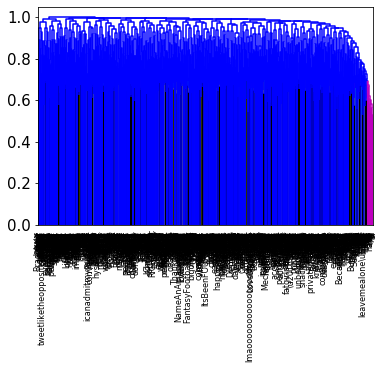

In [167]:
get_clust_graph(Z)

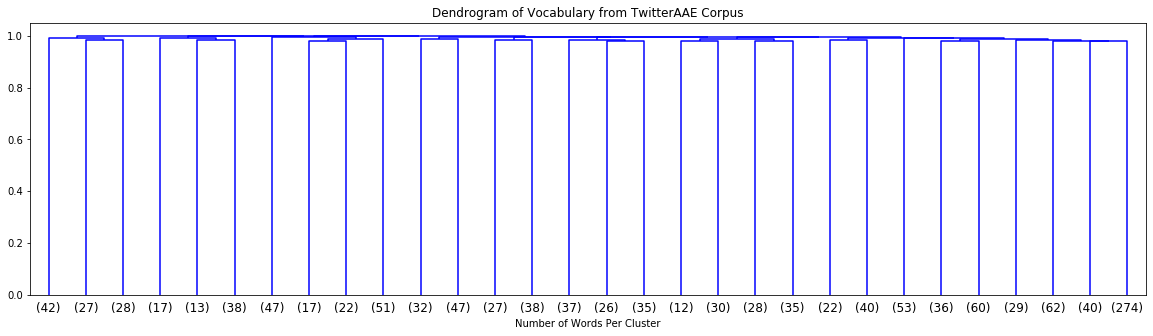

In [92]:
plt.figure(figsize=(20,5))
dendrogram(
    linkage(twitter_w2v.wv.vectors, method="average", metric="cosine"),
    leaf_font_size=12,
    leaf_rotation="0",
    truncate_mode="lastp",
    show_leaf_counts=True,
    count_sort="descending",
#     leaf_label_func=lambda x: str(x)
)
plt.title("Dendrogram of Vocabulary from TwitterAAE Corpus")
plt.xlabel("Number of Words Per Cluster")
plt.show()

### SAE Word2Vec

In [19]:
def leaf_label_func_n(idx):
    return newsgroups_w2v.wv.index2word[idx].replace("$", "\$")

In [20]:
plt.figure(figsize=(200,200))
dendrogram(
    linkage(newsgroups_w2v.wv.vectors, method="average", metric="cosine"),
    leaf_rotation=90,
    leaf_label_func=leaf_label_func_n,
    orientation="left"
)
plt.show()

/Users/alyssahwang/miniconda3/envs/slang/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/alyssahwang/miniconda3/envs/slang/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


In [ ]:
plt.figure(figsize=(20,5))
dendrogram(
    linkage(newsgroups_w2v.wv.vectors, method="average", metric="cosine"),
    leaf_font_size=12,
    leaf_rotation="0",
    truncate_mode="lastp",
    show_leaf_counts=True,
    count_sort="descending",
#     leaf_label_func=lambda x: str(x)
)
plt.title("Dendrogram of Vocabulary from Newsgroups Corpus")
plt.xlabel("Number of Words Per Cluster")
plt.show()

{'g': ['student',
  'DOS',
  'Lots',
  'Herbert',
  '00:11',
  'wasteful',
  'uwast.astro.wisc.edu',
  'vesta.neuroinformatik.ruhr-uni-bochum.de',
  'thingie',
  'Ha',
  'skippy.berkeley.edu',
  'distribute',
  'SYSMGR@CADLAB.ENG.UMD.EDU',
  '1993May16.143120.2248@ucsu',
  'C663u5.IKC@zoo.toronto.edu',
  '129.20.128.2',
  'catalog',
  'SYSMGR@CADLAB.ENG.UMD.EDU',
  'catalog',
  '-|Tom|-',
  '|>>bay',
  '--Lee',
  'disconfirmed',
  'sweep',
  'relaunching',
  'None',
  '1895',
  'Denmark',
  'Hardly',
  'UNIX',
  '8077',
  'carboniferous',
  'sumex-aim.stanford.edu',
  'rover',
  'TVF',
  ';)'],
 'r': ['tongs',
  '-ans',
  'clutching',
  'father',
  'telescopic',
  'Matter',
  'sharing',
  'doubled',
  'accretion',
  'depending',
  'Brookline',
  'converts',
  'HS',
  'wpi.wpi.edu',
  'Nah',
  'Pharabod',
  'reliably',
  'lengthy',
  'civilizations',
  'socialism',
  'unrelated',
  'bare',
  '-rabjab'],
 'c': ['Supercollider',
  'clauses',
  'narcotics',
  'senses',
  'scraped',
  'Incredible',
  'integrals',
  'http://info.cern.ch/hypertext/DataSources/bySubject/Overview.html',
  'Rico',
  'SUPERBOWL',
  'illuminates',
  'conspicuous',
  'bogus',
  'obscured',
  'committee',
  '\n                                                                  \n',
  'inference',
  'alcohol',
  'doomed',
  'committee',
  'crooks',
  'manuvering',
  'relayed',
  'intercluster',
  'angles',
  'Yeah',
  'caged',
  'optimism',
  'apologize',
  'Annoying',
  'failures',
  'Thanak',
  'arena',
  'established',
  'intersupercluster',
  'invisible',
  'refurbished',
  'pointless',
  'refurbishment',
  'Furbanks',
  'builder',
  '447',
  'radial',
  'connect',
  'Suppose',
  'Sparc',
  'OLYMPICS',
  'detects',
  'BUs1',
  '1400',
  'ultimate',
  'participate',
  'moonlit',
  'Order',
  'challenge',
  'powerfull',
  'parabolas',
  'Gee',
  'betcha',
  'pomposity',
  'uplinked',
  'Coming',
  'reflector',
  'inward',
  'curvature',
  'creation',
  'shelf',
  'termite',
  'harmonic',
  'daylight',
  'propaganda',
  'mite',
  'doings',
  'bow',
  'CanadARMs',
  'flashier',
  'distribution(evenly',
  'suddenly',
  'Hexafloride',
  'trenches',
  'wavefront',
  'matching',
  'Significant',
  'reporters',
  'now*.',
  'spoken',
  'aerostats',
  'Sure',
  'salvagable',
  'suspended',
  'lined',
  'removed',
  'quest',
  'notified',
  'Uranium',
  'association',
  'amps',
  'OB',
  'vein',
  'PEROT',
  'redistribute',
  'magnesium',
  'sum',
  'examinations',
  '-60',
  'ancestors',
  'extinguished',
  'cantaloupe',
  'subatomic',
  'covetously',
  'V.A.',
  'Doubtless',
  'don',
  'monday',
  'enveloped',
  'intelegent',
  'smashed',
  'breed',
  'dawn',
  'eliminates',
  'speculatively',
  'triumph',
  '~100',
  'similiar',
  'keyboard',
  'gather',
  'toxic',
  'RV',
  'SR-71s',
  'Comparison',
  'nearside',
  'warmth',
  'seeding',
  'badly',
  'complexion',
  '~45',
  'doubtful',
  'likleihood',
  'Various',
  'READMENEW',
  'mounting',
  'hubble',
  'virus',
  'distorted',
  'undertaking',
  'benefitted',
  'showered',
  'swath',
  'ist',
  'seal',
  'Clinto',
  'stupendous',
  'rugged',
  'partners',
  'vamwendt@upei.ca',
  'particulates',
  'rugged',
  'retraction',
  '2005',
  'economoical',
  'proprietary',
  'belief',
  'behaviour',
  'balky',
  'specifications',
  'manpower',
  'descendents',
  'strive',
  'Geoff',
  'integrate',
  'appended',
  'definite',
  'hauling',
  'asset',
  'CDT',
  'pile',
  'wreck',
  'Pourrnelle',
  'entities',
  'Podlipk',
  'Christianity',
  'explaining',
  'gobbled',
  'kangaroo',
  'estimate',
  'Asia',
  'caps',
  'knowing',
  'stress',
  'Additionally',
  'radioisotope',
  'proving',
  '|equipment',
  'lever',
  'shoves',
  'awesome',
  'planes',
  'starhawk.jpl.nasa.gov',
  'decompression',
  'hoped',
  'Planet',
  'BOUNDARY',
  'suffice',
  'dual',
  'profoundly',
  'deemed',
  'stopping',
  'consent',
  'calculate',
  'heaters',
  'difficulties',
  'atom',
  'gondola',
  'triangulate',
  'Wednesday',
  'particip

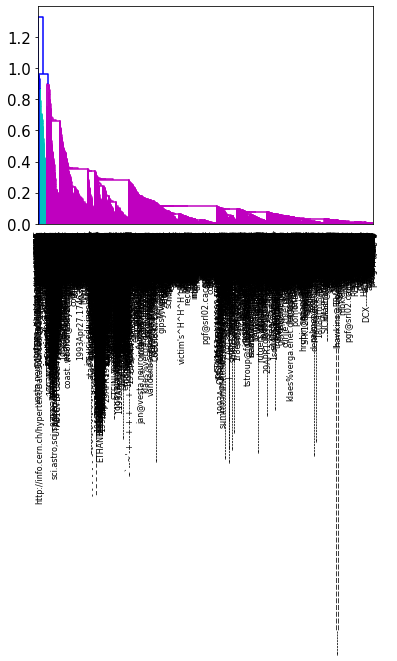

In [26]:
Z_n = linkage(newsgroups_w2v.wv.vectors, method="average", metric="cosine")
get_clust_graph(Z_n)

## GloVe (Pretrained)

# Word2Vec Clustering (Scatter Plot)
I tried to plot the w2v embeddings on a 2D plot with PCA and t-SNE, but neither method shows very meaningful/interpretable results.

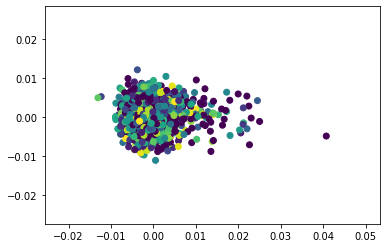

In [60]:
pca = PCA(n_components=2)
twitter_w2v_2d = pca.fit_transform(twitter_w2v.wv.vectors)
plt.scatter(twitter_w2v_2d[:, 0], twitter_w2v_2d[:, 1], c=agglom.labels_)

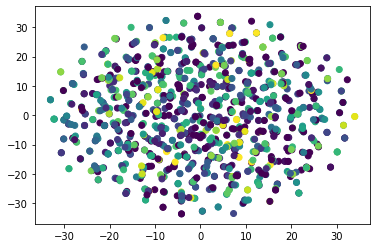

In [108]:
tsne = TSNE(perplexity=1, learning_rate=1)
twitter_w2v_tsne = tsne.fit_transform(twitter_w2v.wv.vectors)
plt.scatter(twitter_w2v_tsne[:, 0], twitter_w2v_tsne[:, 1], c=agglom.labels_)

In [3]:
from nltk.corpus import wordnet as wn

In [30]:
for syn in wn.synsets("hungry") :
    for l in syn.lemmas() :
        print(l.name())

hungry
athirst
hungry
thirsty
